# Object Detection using YOLOv8


## 1. Download the dataset from Kaggle

I will use this dataset from Kaggle for training the YOLOv8: [Fruit Images for Object Detection
](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection/data)


In [ ]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
# Upload your kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"najeebahmadbhuiyan","key":"42ff0056133e89657927143231fe1ee6"}'}

In [ ]:
# Set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 1.22GB/s]


In [ ]:
# Unzip main archive
!unzip -q fruit-images-for-object-detection.zip -d fruit_data



## 2. Main Code

In [ ]:
# Install required packages
!pip install -q ultralytics pyyaml opencv-python
!pip install -q kaggle
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, os, cv2, random, shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
import xml.etree.ElementTree as ET
import yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# ====================
# DATA PREPARATION
# ====================

# Set dataset paths (after unzipping)
train_dir = "/content/fruit_data/train_zip/train"
test_dir = "/content/fruit_data/test_zip/test"

# Create YOLO directory structure
dest_dataset_dir = "dataset"
images_dir = os.path.join(dest_dataset_dir, "images")
labels_dir = os.path.join(dest_dataset_dir, "labels")

for split in ['train', 'val']:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# Class mapping
class_mapping = {"apple": 0, "banana": 1, "orange": 2}

In [ ]:
# ====================
# ANNOTATION CONVERSION
# ====================

def convert_pvoc_to_yolo(width, height, bbox):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    box_width = (x_max - x_min) / width
    box_height = (y_max - y_min) / height
    return (x_center, y_center, box_width, box_height)

def parse_xml_to_yolo(src_dir, split):
    image_files = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]

    for image_file in image_files:
        # Path setup
        src_image_path = os.path.join(src_dir, image_file)
        xml_path = os.path.join(src_dir, os.path.splitext(image_file)[0] + ".xml")
        dest_image_path = os.path.join(images_dir, split, image_file)
        dest_label_path = os.path.join(labels_dir, split, os.path.splitext(image_file)[0] + ".txt")

        # Copy image
        shutil.copy2(src_image_path, dest_image_path)

        # Get actual image dimensions
        with Image.open(src_image_path) as img:
            width, height = img.size

        # Parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        with open(dest_label_path, 'w') as f:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in class_mapping:
                    continue

                bbox = obj.find('bndbox')
                bbox_coords = (
                    float(bbox.find('xmin').text),
                    float(bbox.find('ymin').text),
                    float(bbox.find('xmax').text),
                    float(bbox.find('ymax').text)
                )

                yolo_bbox = convert_pvoc_to_yolo(width, height, bbox_coords)
                f.write(f"{class_mapping[class_name]} {' '.join(map(str, yolo_bbox))}\n")

# Convert datasets
parse_xml_to_yolo(train_dir, 'train')
parse_xml_to_yolo(test_dir, 'val')

In [ ]:
# ====================
# DATA CONFIGURATION
# ====================

# Create data.yaml
yaml_content = f"""
train: {images_dir}/train
val: {images_dir}/val

nc: {len(class_mapping)}
names: {list(class_mapping.keys())}
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

In [ ]:
# ====================
# MODEL TRAINING
# ====================

# Initialize and train model
model = YOLO('yolov8n.pt')  # Load pretrained model
results = model.train(
    data='data.yaml',
    epochs=100,
    batch=32,
    imgsz=640,
    workers=2,
    name='fruit_detection'
)

# Save trained model
model.export(format='onnx')  # Export to ONNX for better compatibility
best_model_path = '/content/runs/detect/fruit_detection/weights/best.pt'
shutil.copy(best_model_path, '/content/best_fruit_detection.pt')

Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruit_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751897  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1544.3±866.2 MB/s, size: 87.7 KB)


train: Scanning /content/dataset/labels/train... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 1961.41it/s]

train: /content/dataset/images/train/apple_62.jpg: corrupt JPEG restored and saved
train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 920.2±955.5 MB/s, size: 227.1 KB)


val: Scanning /content/dataset/labels/val... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 1618.62it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/fruit_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/fruit_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.83G      1.209      3.147      1.551         66        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all         60        117    0.00615       0.94      0.285      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.71G      1.103      2.656      1.438         88        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         60        117    0.00634      0.976      0.442      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.73G      1.081      1.928      1.412         80        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         60        117      0.703      0.189      0.606      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.75G      1.024      1.522       1.33         75        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         60        117      0.667      0.517      0.645       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.77G      1.053      1.426      1.355         86        640: 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         60        117      0.718      0.553      0.662       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.78G       1.07      1.418      1.361         94        640: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         60        117      0.695      0.591       0.69      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.81G      1.065      1.345      1.341         80        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         60        117      0.718      0.641      0.718      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.83G      1.021      1.262      1.295         69        640: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         60        117      0.657      0.567      0.681      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.84G     0.9865      1.232      1.304         60        640: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         60        117      0.425      0.545      0.574      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.86G      1.008      1.182      1.294         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         60        117      0.613      0.724      0.694      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.88G      1.013      1.228      1.326         69        640: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         60        117      0.697      0.661      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.89G     0.9792      1.205       1.29         69        640: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         60        117      0.743      0.642      0.728      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.91G     0.9898      1.137      1.289         74        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         60        117      0.592      0.611       0.62      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.93G     0.9656       1.12      1.283         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         60        117      0.621      0.686      0.674      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.95G     0.9807      1.133      1.289         78        640: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         60        117      0.704      0.707      0.752       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.96G       1.02      1.148       1.32         84        640: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         60        117      0.804      0.692      0.793      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.98G      1.005      1.057      1.302         69        640: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         60        117      0.769      0.734      0.796      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         5G     0.9657      1.015      1.268         60        640: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         60        117      0.781       0.65      0.746       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.01G     0.9776      1.005      1.255         94        640: 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         60        117      0.647      0.423      0.509      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.03G     0.9808      1.006      1.279         51        640: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         60        117      0.567      0.559      0.514      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.05G     0.9764      1.013      1.258         88        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         60        117      0.627       0.57      0.589      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.06G      1.052      1.027      1.343         60        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         60        117       0.59      0.702      0.657      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.08G      1.003       1.04      1.276         68        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         60        117      0.633      0.679      0.667      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       5.1G     0.9524     0.9783      1.275         82        640: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         60        117      0.606      0.629      0.691      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.12G     0.9434     0.9134      1.261         76        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         60        117      0.708       0.71      0.753      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.14G     0.8925     0.8871      1.216         64        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         60        117      0.775      0.688      0.747      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.15G     0.9477        0.9      1.248         97        640: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         60        117      0.817      0.803      0.815      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.17G     0.9093     0.8779       1.23         90        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         60        117      0.876      0.757      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.18G     0.9213     0.9077      1.237         68        640: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         60        117      0.786      0.727      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       5.2G     0.8923     0.8637      1.211        109        640: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         60        117       0.73      0.706      0.783      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.22G     0.8891     0.8392      1.203        100        640: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         60        117      0.747      0.627      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.24G     0.8787     0.8307      1.204         79        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         60        117      0.802      0.755      0.833      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.26G     0.8735     0.8132      1.209         65        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         60        117      0.835      0.838       0.89      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.27G     0.8857     0.8316      1.205         71        640: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         60        117      0.919      0.786      0.912      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.29G     0.8863     0.8014      1.209         84        640: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         60        117      0.885      0.788      0.904      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       5.3G     0.8288     0.7404      1.161         74        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         60        117      0.789      0.807      0.883      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.32G      0.868      0.763      1.196         58        640: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         60        117      0.818      0.837      0.884      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.34G     0.8553      0.773      1.196        100        640: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         60        117      0.866      0.773      0.858      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.36G     0.8142     0.7089      1.158         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         60        117       0.92      0.728      0.859      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.37G     0.8258     0.7264      1.166         78        640: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         60        117      0.857      0.756      0.837      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.39G     0.8288     0.7325      1.159         55        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         60        117      0.834      0.816       0.86      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.41G     0.8277     0.7049      1.159         63        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         60        117      0.861      0.833      0.918      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.42G     0.8289     0.7104      1.159         75        640: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         60        117      0.845      0.806      0.899      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.44G     0.8074     0.7178      1.168         78        640: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         60        117      0.818      0.821      0.886      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.46G     0.8115     0.7173       1.16         70        640: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         60        117      0.829      0.856      0.893      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.48G     0.8195     0.7072      1.154         92        640: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         60        117       0.88      0.807      0.871       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.49G     0.7937     0.7077      1.169         64        640: 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         60        117      0.788      0.838      0.877      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.51G     0.7793     0.6727      1.151         71        640: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         60        117      0.911      0.743      0.881      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.53G     0.7881     0.6776      1.147         83        640: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         60        117      0.797      0.824      0.873      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.54G     0.7357     0.6517      1.117         61        640: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         60        117      0.902       0.78      0.879      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.56G     0.7765     0.6454       1.14         79        640: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         60        117      0.878      0.818      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.58G     0.7715     0.6793      1.141         83        640: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         60        117      0.842       0.77      0.858      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       5.6G     0.7807      0.645      1.141         85        640: 100%|██████████| 8/8 [00:03<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         60        117      0.885      0.809      0.885      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.61G     0.7393     0.6364      1.124         99        640: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         60        117      0.902      0.782      0.909      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.63G     0.7695     0.6321      1.121         80        640: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         60        117      0.935      0.777      0.909      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.64G     0.7384     0.6298      1.115         77        640: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         60        117      0.857      0.796      0.891      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.66G     0.7148     0.6288      1.123         76        640: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         60        117      0.885      0.804      0.915      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.68G     0.7433     0.6224      1.141         69        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         60        117      0.883      0.888      0.936      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       5.7G     0.7127     0.5847      1.085         73        640: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         60        117      0.893      0.832      0.914      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.71G     0.7497     0.6362       1.13         82        640: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         60        117      0.864      0.889      0.922      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.73G     0.7396     0.5956      1.116         75        640: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         60        117      0.885      0.846      0.913      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.75G     0.7425     0.6159      1.128         88        640: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         60        117      0.882      0.878      0.915      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.77G     0.6857     0.5765      1.093         61        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         60        117      0.903       0.85      0.912      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.79G     0.7295     0.5826      1.122         63        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         60        117      0.904      0.838      0.926      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       5.8G     0.7247     0.5768      1.098         86        640: 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         60        117      0.903      0.858       0.93      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.82G     0.6769     0.5247      1.076         84        640: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         60        117       0.94      0.815      0.929      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.83G     0.6947     0.5475      1.091         69        640: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         60        117      0.906      0.817      0.924      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.85G     0.6757     0.5479      1.099         77        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         60        117      0.897      0.824      0.913      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.87G     0.6852      0.543      1.077         84        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         60        117      0.883      0.876      0.921      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.88G     0.6762     0.5374      1.096         78        640: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         60        117       0.88      0.874      0.941      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       5.9G     0.6767     0.5344      1.084         75        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         60        117      0.898      0.881      0.948      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.92G     0.6706     0.5409      1.066         68        640: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         60        117      0.879      0.865      0.935      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.94G     0.6687     0.5273      1.075         70        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         60        117      0.903      0.868      0.926      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.95G     0.6395     0.5383      1.075         74        640: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         60        117      0.932      0.868      0.929      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.97G     0.6566     0.5378      1.071         93        640: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         60        117      0.935      0.808      0.923       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.99G     0.6555     0.5061      1.074         68        640: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         60        117      0.964      0.815      0.938      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         6G     0.6096      0.493      1.041         56        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         60        117      0.918       0.88      0.937      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.02G     0.6182     0.5099       1.05         71        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         60        117      0.909      0.829      0.924      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.04G     0.6411     0.5133      1.074         68        640: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         60        117      0.825      0.861      0.903      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.05G     0.6119     0.4834      1.044         73        640: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         60        117       0.93      0.779      0.905      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.07G     0.5962     0.4879      1.031         62        640: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         60        117      0.953      0.817      0.932      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.09G       0.63     0.4825       1.06         73        640: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         60        117      0.921      0.889      0.956      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.11G     0.6309     0.4854      1.065         68        640: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         60        117      0.848      0.949      0.953      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.12G     0.6433     0.5333      1.063         81        640: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         60        117      0.903      0.894      0.946      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.14G     0.5979     0.4701      1.045         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         60        117      0.871      0.909      0.939      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.16G     0.5997     0.4797      1.053         57        640: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         60        117      0.849      0.908      0.921      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.18G     0.5983     0.4766      1.044         59        640: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         60        117      0.869      0.866      0.924      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.19G     0.5983     0.4782      1.043         65        640: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         60        117      0.876      0.828      0.921      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.21G      0.592     0.4851       1.04         67        640: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         60        117      0.948       0.81      0.933      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.23G     0.5563     0.4512      1.013         71        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         60        117      0.942      0.832      0.935      0.689


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.25G     0.4967     0.4553     0.9702         38        640: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         60        117      0.965      0.839      0.937      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.26G     0.4846     0.4076     0.9739         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         60        117      0.963      0.831      0.925      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.28G     0.4613        0.4     0.9571         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         60        117      0.935      0.862      0.933      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.29G     0.4563     0.3704     0.9583         35        640: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         60        117      0.914      0.879       0.93      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.31G     0.4516     0.3617     0.9399         32        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         60        117      0.895      0.897      0.928      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.33G     0.4508     0.3653     0.9515         27        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         60        117       0.91      0.884      0.941      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.35G     0.4447     0.3654     0.9601         32        640: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         60        117      0.902      0.902      0.941      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.36G     0.4276     0.3544      0.942         42        640: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         60        117      0.934      0.857      0.928      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.38G     0.4282     0.3524     0.9515         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         60        117      0.944      0.856      0.926      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.4G     0.4246      0.352      0.943         31        640: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         60        117      0.935      0.857      0.926      0.701



100 epochs completed in 0.128 hours.
Optimizer stripped from runs/detect/fruit_detection/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/fruit_detection/weights/best.pt, 6.3MB

Validating runs/detect/fruit_detection/weights/best.pt...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


                   all         60        117       0.91      0.884      0.941      0.714
                 apple         24         35      0.917      0.914      0.958      0.816
                banana         22         40      0.865       0.85      0.918       0.59
                orange         22         42      0.949      0.889      0.947      0.737
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/fruit_detection
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/fruit_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 

'/content/best_fruit_detection.pt'

Testing: mixed_22.jpg

image 1/1 /content/fruit_data/test_zip/test/mixed_22.jpg: 640x640 1 apple, 1 banana, 1 orange, 8.2ms
Speed: 4.6ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


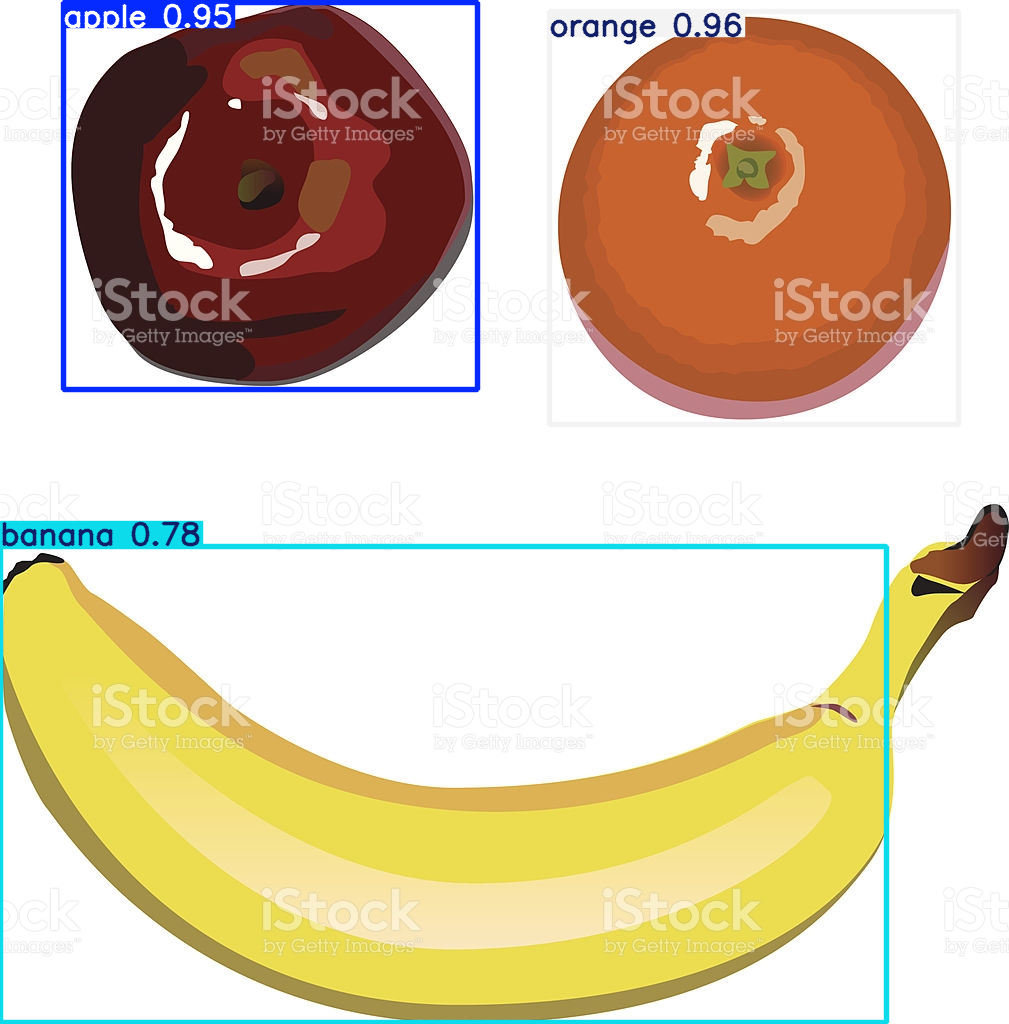

Testing: banana_79.jpg

image 1/1 /content/fruit_data/test_zip/test/banana_79.jpg: 416x640 1 banana, 14.5ms
Speed: 3.7ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


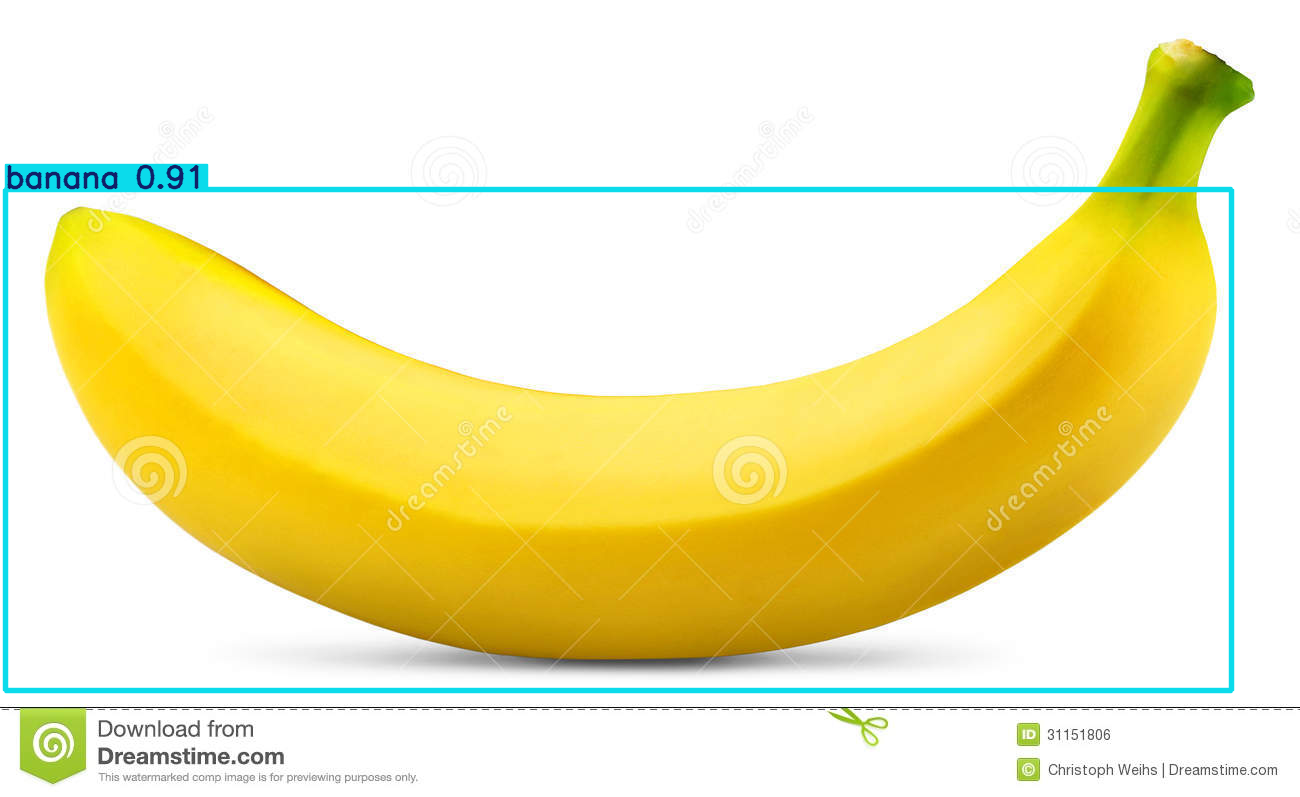

Testing: orange_95.jpg

image 1/1 /content/fruit_data/test_zip/test/orange_95.jpg: 640x640 1 orange, 11.2ms
Speed: 6.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


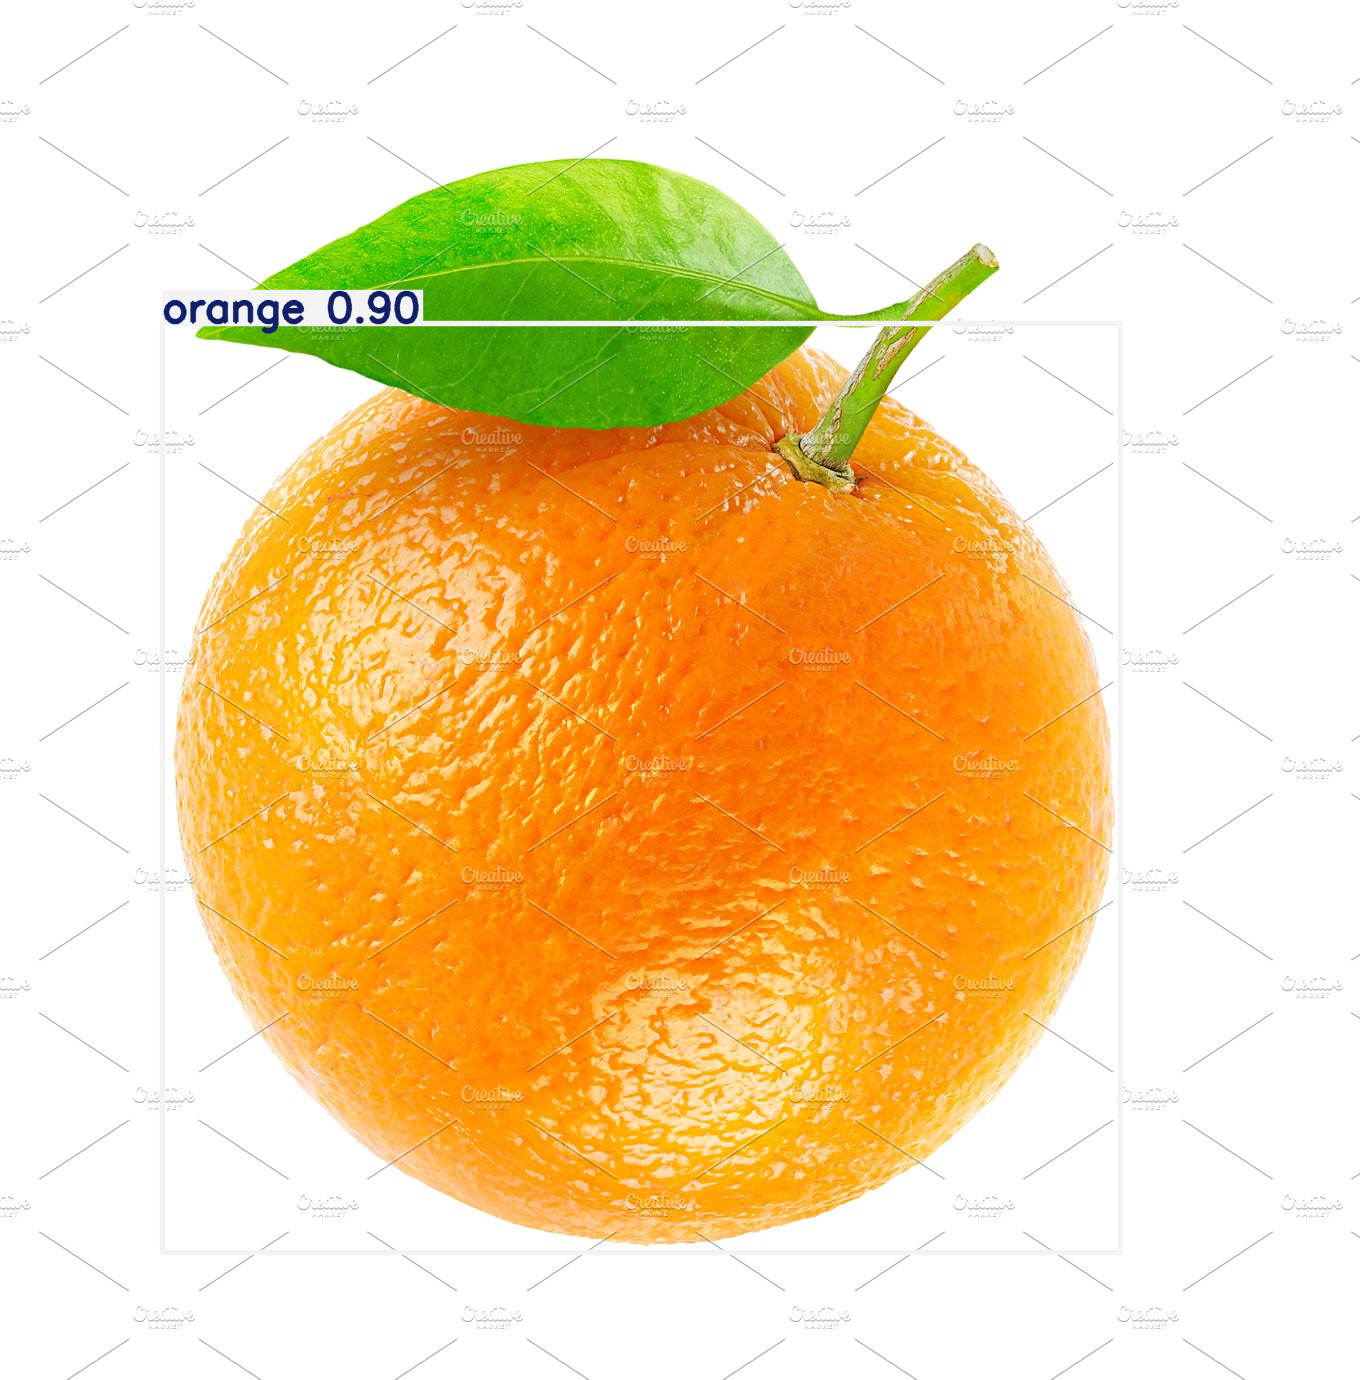

Testing: apple_88.jpg

image 1/1 /content/fruit_data/test_zip/test/apple_88.jpg: 640x640 (no detections), 11.7ms
Speed: 5.6ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


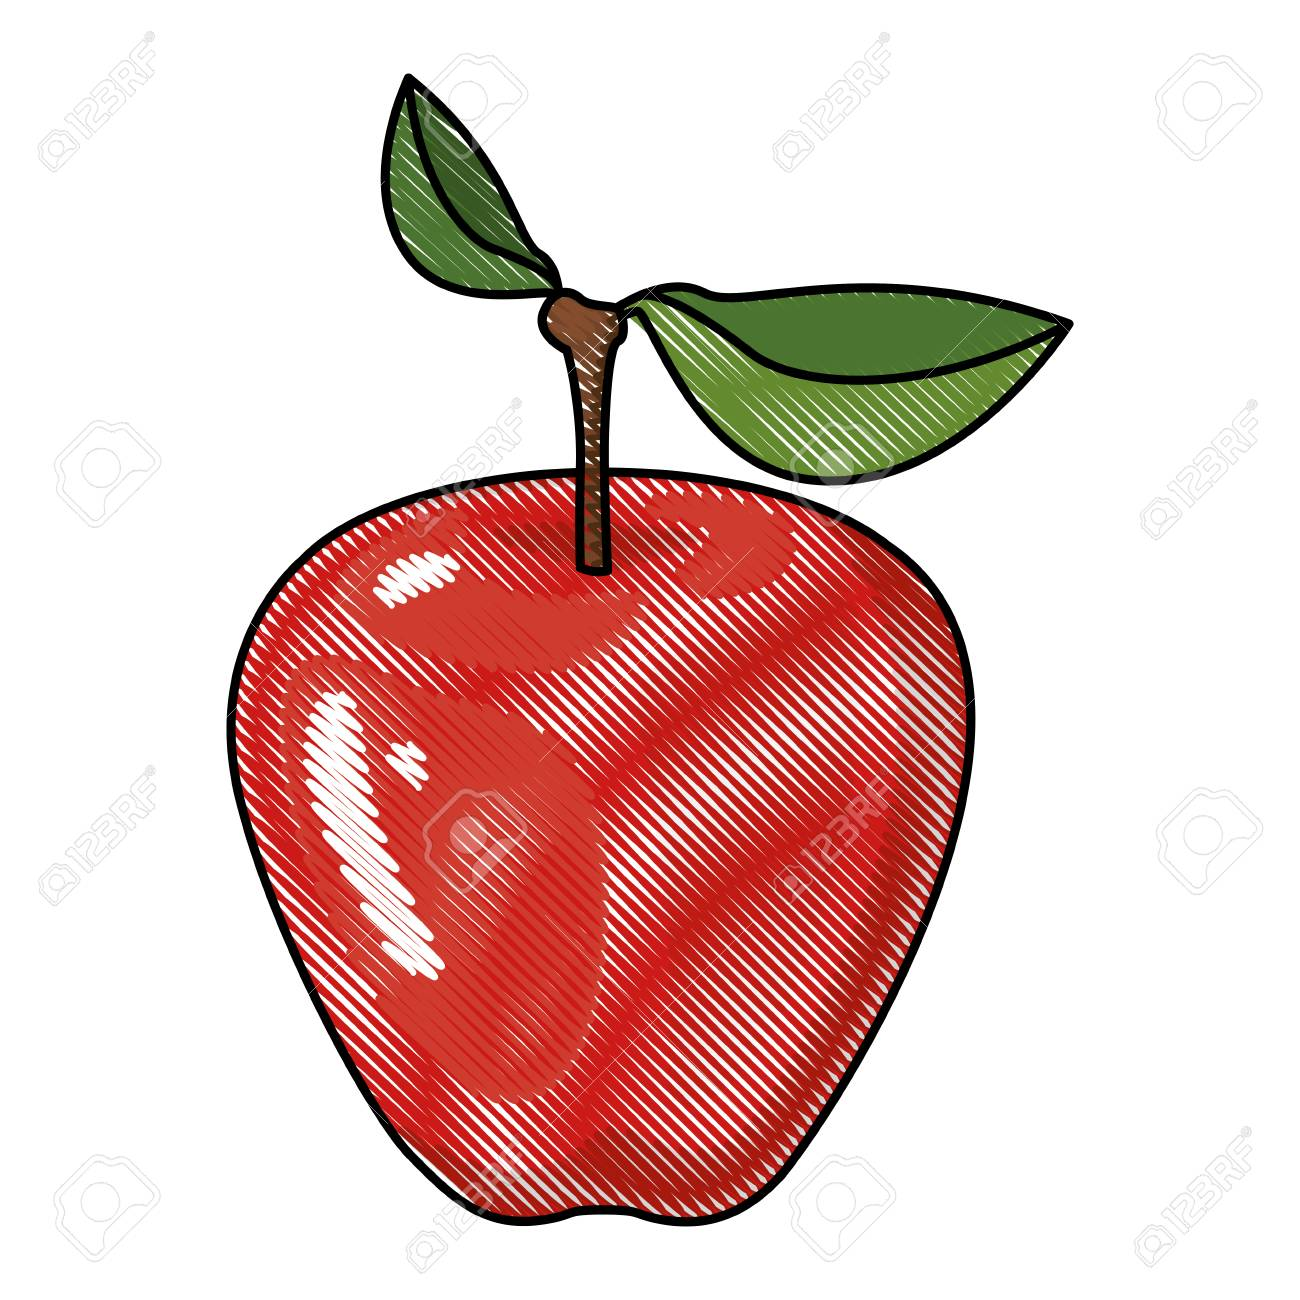

In [ ]:
# ====================
# MODEL TESTING
# ====================

# Load best model
best_model = YOLO('/content/best_fruit_detection.pt')

# Inference function
def detect_fruits(model, image_path):
    results = model(image_path)
    for r in results:
        im_array = r.plot()  # Plot with bounding boxes
        im = Image.fromarray(im_array[..., ::-1])  # Convert to PIL format
        display(im)

# Test on sample images
test_samples = [
    "/content/fruit_data/test_zip/test/mixed_22.jpg",
    "/content/fruit_data/test_zip/test/banana_79.jpg",
    "/content/fruit_data/test_zip/test/orange_95.jpg",
    "/content/fruit_data/test_zip/test/apple_88.jpg"
]

for img_path in test_samples:
    print(f"Testing: {os.path.basename(img_path)}")
    detect_fruits(best_model, img_path)